# Baseline Flat Classification

This notebook trains a **flat (non-hierarchical) classifier** on the merged 3D MedMNIST datasets for comparison with the hierarchical approach.

The flat classifier predicts the fine-grained label directly without the intermediate region classification step.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from medmnist import INFO
import os

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)

from utils.data_loader import create_hierarchical_dataset
from utils.cnn_3d_models import get_3d_model
from utils.trainer import Trainer
from utils.metrics import compute_comprehensive_metrics
set_seed(42)
print(f"Device: {DEVICE}")

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

GPU detected: NVIDIA GeForce RTX 3060 Ti
GPU memory: 8.59 GB
Device: cuda


## 1. Load Merged Dataset

In [ ]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers'],
    return_global_labels=True 
)

print("="*60)
print("MERGED DATASET INFO")
print("="*60)
# 1. Basic info table
basic_info = pd.DataFrame([{
    'Total Fine Classes': dataset_info['num_fine_classes'],
    'Train Samples': dataset_info['train_samples'],
    'Val Samples': dataset_info['val_samples'],
    'Test Samples': dataset_info['test_samples']
}])
print("\nDataset Overview:")
display(
    basic_info.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
)
# 2. Global Fine Label Mapping for Flat Classifier
print("\nGlobal Fine Label Mapping (for Flat Classifier):")
rows = []
global_map = dataset_info['global_idx_to_name']

for global_idx in sorted(global_map.keys()):
    info = global_map[global_idx]
    rows.append({
        'Global Index': int(global_idx),
        'Region': info['region'].upper(),
        'Dataset': info['dataset'].upper(),
        'Label Name': info['name']
    })
df_labels = pd.DataFrame(rows)
# Display with specific alignment
display(
    df_labels.style
    .hide(axis="index")
    .set_properties(subset=['Global Index', 'Region', 'Dataset'], **{'text-align': 'center'})
    .set_properties(subset=['Label Name'], **{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'th.col3', 'props': [('text-align', 'left')]} # Left align 'Label Name' header
    ])
)


Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz


## 2. Create Wrapper DataLoaders for Flat Training



In [ ]:
class FlatDataLoaderWrapper:
    """Wrapper that extracts only (img, global_fine_label) from hierarchical dataloader."""
    def __init__(self, hierarchical_loader):
        self.loader = hierarchical_loader
    
    def __iter__(self):
        # Unpack 4 values: img, coarse, fine_local, fine_global
        for imgs, coarse_labels, fine_labels, global_fine_labels in self.loader:
            # Yield image and GLOBAL label (0-19)
            yield imgs, global_fine_labels
    
    def __len__(self):
        return len(self.loader)

# Create flat loaders
flat_train_loader = FlatDataLoaderWrapper(train_loader)
flat_val_loader = FlatDataLoaderWrapper(val_loader)
flat_test_loader = FlatDataLoaderWrapper(test_loader)

print("\nFlat data loaders created")


Flat data loaders created


## 3. Build Flat Classifier

In [ ]:
# Create flat classifier
num_classes = dataset_info['num_fine_classes']
architecture = MODEL_CONFIG['architecture']

# Instantiate model
model = get_3d_model(
    model_name=architecture,
    num_classes=num_classes
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nFlat classifier created:")

# Create summary table
model_summary = pd.DataFrame([{
    'Architecture': architecture,
    'Input Channels': 1,  # Assuming grayscale medical images
    'Output Classes': num_classes,
    'Total Parameters': f"{total_params:,}",
    'Trainable Parameters': f"{trainable_params:,}",
    'Device': str(DEVICE)
}])
# Display styled table
display(
    model_summary.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]}
    ])
)


Flat classifier created:


Architecture,Input Channels,Output Classes,Total Parameters,Trainable Parameters,Device
efficientnet3d_b0,1,20,"1,231,124","1,231,124",cuda


## 4. Train Flat Classifier

In [ ]:
# Create trainer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

trainer = Trainer(
    model=model,
    train_loader=flat_train_loader,
    val_loader=flat_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler
)

# Total epochs = coarse + fine epochs for fair comparison
total_epochs = TRAINING_CONFIG['coarse_epochs'] + TRAINING_CONFIG['fine_epochs']
print(f"Training for {total_epochs} epochs...")

Training for 4 epochs...


In [ ]:
# Train
history = trainer.train(num_epochs=total_epochs)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


Epoch 1/4


Validation: 100%|██████████| 45/45 [00:27<00:00,  1.66it/s]


Train Loss: 1.5876, Train Acc: 0.4483
Val Loss: 1.4190, Val Acc: 0.4735
New best validation accuracy: 0.4735

Epoch 2/4


Validation: 100%|██████████| 45/45 [00:26<00:00,  1.72it/s]


Train Loss: 1.2175, Train Acc: 0.5464
Val Loss: 0.9870, Val Acc: 0.6212
New best validation accuracy: 0.6212

Epoch 3/4


Validation: 100%|██████████| 45/45 [00:25<00:00,  1.74it/s]


Train Loss: 1.0995, Train Acc: 0.5848
Val Loss: 1.1296, Val Acc: 0.5585
Early Stopping Counter: 1/10

Epoch 4/4


Validation: 100%|██████████| 45/45 [00:27<00:00,  1.63it/s]

Train Loss: 0.9855, Train Acc: 0.6096
Val Loss: 1.0039, Val Acc: 0.5766
Early Stopping Counter: 2/10

TRAINING COMPLETE!


## 5. Training Visualization

Figure saved to: c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\models\flat-classifiers\efficientnet3d_b0\baseline_training_efficientnet3d_b0.png


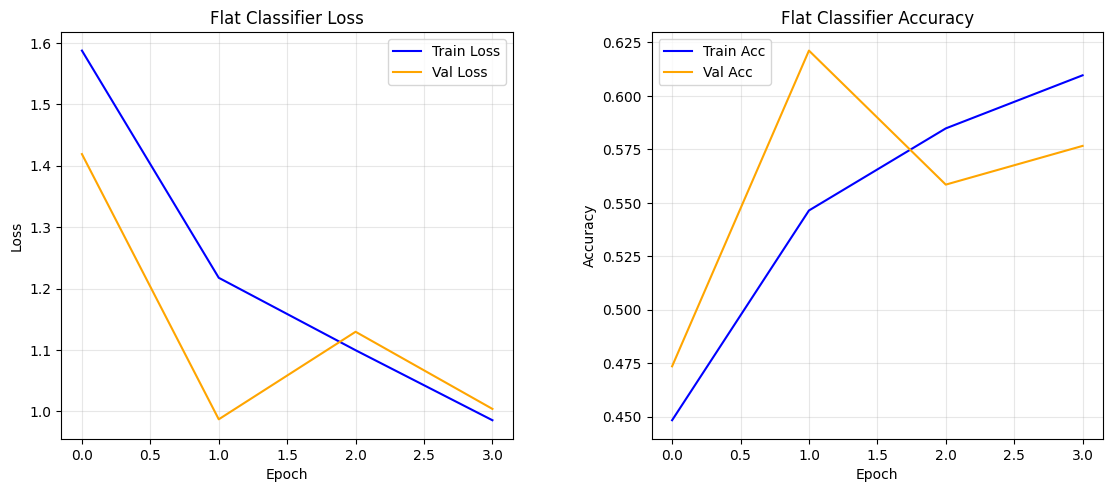

In [ ]:
save_dir = os.path.join(PATHS['models'], 'flat-classifiers', architecture)
os.makedirs(save_dir, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Flat Classifier Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Flat Classifier Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.subplots_adjust(wspace=200)
plt.tight_layout(pad=1.0)

fig_path = os.path.join(save_dir, f'baseline_training_{architecture}.png')
plt.savefig(fig_path, dpi=150)
print(f"Figure saved to: {fig_path}")
plt.show()

## 6. Evaluation on Test Set

In [ ]:
def evaluate_flat_model(model, test_loader, device, dataset_info):
    """Evaluate a flat (non-hierarchical) model on the test set and compute metrics."""
    from utils.metrics import compute_metrics
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import label_binarize
    import numpy as np
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Run inference on the test set
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            labels = labels.squeeze(-1).long().to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    label_names = [dataset_info['global_idx_to_name'][i]['name'] for i in range(dataset_info['num_fine_classes'])]
    
    # Base metrics
    metrics = compute_metrics(all_labels, all_preds, labels=label_names)
    
    # AUC Metrics
    all_probs = np.array(all_probs)
    n_classes = len(label_names)
    labels_bin = label_binarize(all_labels, classes=range(n_classes))
    
    try:
        metrics['auc_macro'] = roc_auc_score(labels_bin, all_probs, average='macro', multi_class='ovr')
        metrics['auc_weighted'] = roc_auc_score(labels_bin, all_probs, average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"Could not compute global AUC: {e}")
        metrics['auc_macro'] = 0.0
        metrics['auc_weighted'] = 0.0
    
    # Per-class AUC
    per_class_auc = []
    for i in range(n_classes):
        try:
            if len(np.unique(labels_bin[:, i])) > 1:
                auc = roc_auc_score(labels_bin[:, i], all_probs[:, i])
            else:
                auc = 0.0
        except:
            auc = 0.0
        per_class_auc.append(auc)
    
    metrics['per_class']['auc'] = per_class_auc
    
    return metrics


EVALUATING ON TEST SET


Evaluating: 100%|██████████| 115/115 [00:26<00:00,  4.28it/s]



Accuracy:  0.5924
F1-Score:  0.5056
AUC:       0.9619


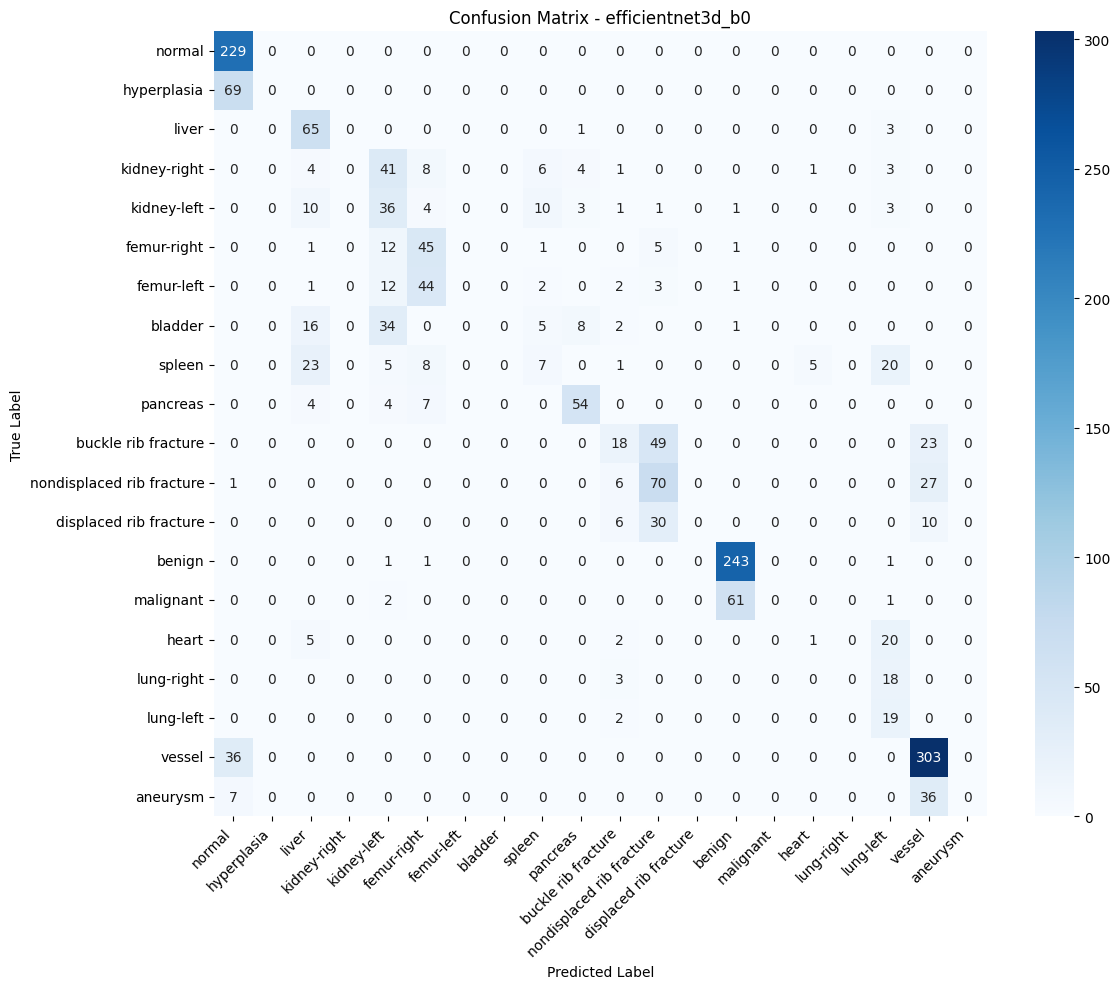

In [ ]:

print("="*80)
print("EVALUATING ON TEST SET")
print("="*80)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Run Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(flat_test_loader, desc="Evaluating"):
        if len(batch) == 3:
            imgs, _, labels = batch
        else:
            imgs, labels = batch[:2]
            
        imgs = imgs.to(DEVICE, dtype=torch.float32)
        if imgs.max() > 1:
            imgs = imgs / 255.0
        
        labels = labels.long().to(DEVICE)
        
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.concatenate(all_probs, axis=0)

# Get class names
class_names = [f"Class_{i}" for i in range(dataset_info['num_fine_classes'])]
if 'global_idx_to_name' in dataset_info:
    class_names = [dataset_info['global_idx_to_name'][i]['name'] for i in range(dataset_info['num_fine_classes'])]

# 2. Compute Metrics
metrics = compute_comprehensive_metrics(
    y_true, y_pred, y_probs, class_names=class_names
)

print(f"\nAccuracy:  {metrics['accuracy']:.4f}")
print(f"F1-Score:  {metrics['f1_weighted']:.4f}")
if 'auc_weighted' in metrics:
    print(f"AUC:       {metrics['auc_weighted']:.4f}")

# 3. Plot Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {MODEL_CONFIG["architecture"]}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Save Model and Results

In [ ]:
# Create output directory
output_dir = f"{PATHS['models']}/flat-classifiers/{MODEL_CONFIG['architecture']}"
os.makedirs(output_dir, exist_ok=True)

# 4. Save Standardized Metrics JSON
full_metrics = {
    "model_type": "flat",
    "architecture": MODEL_CONFIG['architecture'],
    "metrics": metrics,
    "training_history": {
        "best_val_acc": float(best_val_acc),
        "final_train_loss": float(history['train_loss'][-1]) if history['train_loss'] else None
    }
}

json_path = f"{output_dir}/metrics.json"
save_metrics_json(full_metrics, json_path)
print(f"\nMetrics saved to: {json_path}")

# 5. Save Model State
torch.save(model.state_dict(), f"{output_dir}/model.pth")
print(f"Model saved to: {output_dir}/model.pth")

NameError: name 'best_val_acc' is not defined